In [1]:
# read file and create graph

import networkx as nx
import matplotlib.pyplot as plt

# graph representing the bgp network based
bgpNetwork = nx.DiGraph()

with open("bview.20250301.1600.txt", 'r') as file:
    lines = file.readlines()

for line in lines:
    # get the AS path out of the line
    splitLine = line.split("|")
    asPath = splitLine[6]
    pathNodes = asPath.split(" ")

    # need reversed path since path structure is [currentNode, heardFrom, heardFrom... , origin]
    reversedPath = pathNodes[::-1]

    # if this is the origin of the announcement
    if len(reversedPath) == 1:
        bgpNetwork.add_node(reversedPath[0])

    # otherwise we have multiple ASNs we add an edge from i to i + 1 to capture the full route
    else:
        for i in range(len(reversedPath) - 1):
            if not reversedPath[i] == reversedPath[i + 1]:
                bgpNetwork.add_edge(reversedPath[i], reversedPath[i + 1])

print("Graph created")
print(bgpNetwork.number_of_nodes())
print(bgpNetwork.number_of_edges())

Graph created
84009
168808


In [2]:
# helper function

def bgpSubgraph(asn):
    subgraphNodes = [asn] + list(bgpNetwork.neighbors(asn))
    subgraph = bgpNetwork.subgraph(subgraphNodes)
    return subgraph
    

8
40


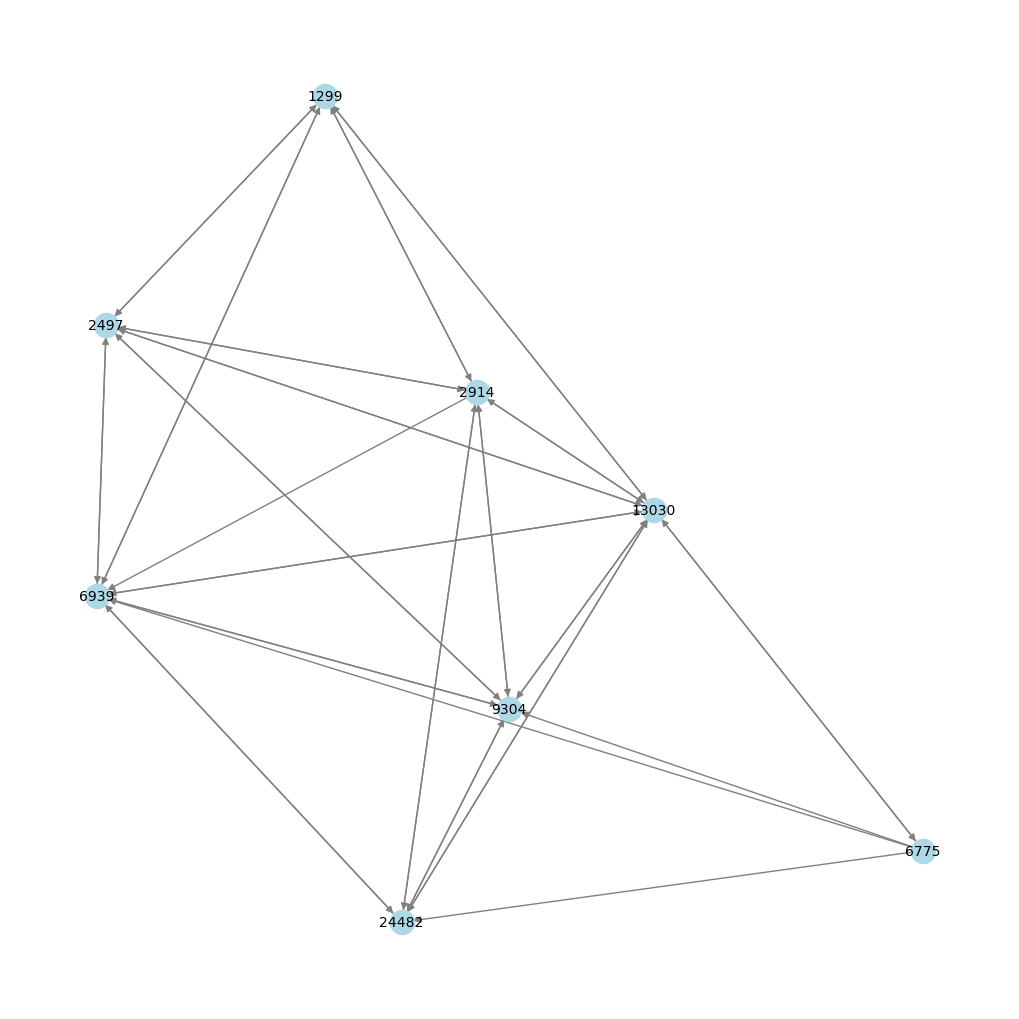

In [3]:
# test use of bgpSubgraph

test = bgpSubgraph("13030")
print(test.number_of_nodes())
print(test.number_of_edges())


pos = nx.spring_layout(test, k=0.8)
plt.figure(figsize=(10, 10))
nx.draw(test, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
plt.show()

In [ ]:
import pandas as pd
# Node features to input into Machine Learning Algo 

# out-degrees dictionary 
out_degree_dict = dict(bgpNetwork.out_degree())

# convert to DataFrame for ML
df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['out_degree'])

# to add more columns (features) to the table 
#df['column name'] = values 

print("Out-degree of ASNs:")
print(df.head())


Out-degree of ASNs:
       out_degree
749             1
3356           50
1299           51
13030           7
2914           36
